In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# ==========================================
# 1. TẢI VÀ TIỀN XỬ LÝ DỮ LIỆU
# ==========================================

# Đọc file dataset
df = pd.read_csv('dataset/IMDB Dataset.csv')

# Kiểm tra dữ liệu
print("Dữ liệu mẫu:")
print(df.head())

# Hàm làm sạch văn bản (quan trọng với IMDB vì chứa thẻ HTML <br />)
def clean_text(text):
    text = text.lower() # Chuyển về chữ thường
    text = re.sub(r'<br\s*/?>', ' ', text) # Loại bỏ thẻ HTML <br />
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # Loại bỏ ký tự đặc biệt
    return text

# Áp dụng làm sạch
df['review'] = df['review'].apply(clean_text)

# Chuyển đổi nhãn (sentiment): positive -> 1, negative -> 0
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Tách dữ liệu review và label
sentences = df['review'].values
labels = df['sentiment'].values

# Chia tập train và test (80% train, 20% test)
# (Lưu ý: Dataset này có 50k dòng, việc chia này giúp model tổng quát hóa tốt hơn)
training_sentences, testing_sentences, training_labels, testing_labels = train_test_split(
    sentences, labels, test_size=0.2, random_state=42
)

Dữ liệu mẫu:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [3]:
# ==========================================
# 2. TOKENIZATION & PADDING
# ==========================================

# Các tham số cấu hình (Hyperparameters)
vocab_size = 10000      # Số lượng từ vựng tối đa (lấy 10k từ phổ biến nhất)
embedding_dim = 16      # Số chiều vector embedding
max_length = 120        # Độ dài tối đa của một review (cắt hoặc thêm padding)
trunc_type = 'post'     # Cắt phía sau nếu dài hơn max_length
oov_tok = "<OOV>"       # Ký tự thay thế cho từ không có trong từ điển

# Khởi tạo Tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

# Chuyển text sang sequences (chuỗi số)
training_sequences = tokenizer.texts_to_sequences(training_sentences)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)

# Padding để độ dài các câu bằng nhau
training_padded = pad_sequences(training_sequences, maxlen=max_length, truncating=trunc_type)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, truncating=trunc_type)

# Chuyển sang numpy array để đưa vào model TensorFlow
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [4]:
# ==========================================
# 3. XÂY DỰNG MÔ HÌNH (MODEL ARCHITECTURE)
# ==========================================

model = tf.keras.Sequential([
    # Lớp Embedding: Chuyển số nguyên thành vector dày đặc
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    
    # Lớp LSTM (Bidirectional): Học ngữ cảnh 2 chiều, phù hợp cho NLP
    # Nếu đề bài yêu cầu đơn giản hơn có thể dùng Flatten() hoặc GlobalAveragePooling1D()
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    
    # Lớp Dense: Mạng nơ-ron kết nối đầy đủ
    tf.keras.layers.Dense(24, activation='relu'),
    
    # Lớp Output: 1 nơ-ron với hàm Sigmoid (trả về xác suất từ 0 đến 1)
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile mô hình
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

C:\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [5]:
# ==========================================
# 4. HUẤN LUYỆN MÔ HÌNH (TRAINING)
# ==========================================

num_epochs = 5 # Số vòng lặp huấn luyện

history = model.fit(
    training_padded, 
    training_labels, 
    epochs=num_epochs, 
    validation_data=(testing_padded, testing_labels), 
    verbose=1
)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - accuracy: 0.7911 - loss: 0.4291 - val_accuracy: 0.8395 - val_loss: 0.3654
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.8799 - loss: 0.2879 - val_accuracy: 0.8501 - val_loss: 0.3460
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.9075 - loss: 0.2283 - val_accuracy: 0.8497 - val_loss: 0.3718
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.9316 - loss: 0.1750 - val_accuracy: 0.8472 - val_loss: 0.4044
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.9524 - loss: 0.1279 - val_accuracy: 0.8353 - val_loss: 0.5088


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8353 - loss: 0.5088

Độ chính xác trên tập Test: 83.53%


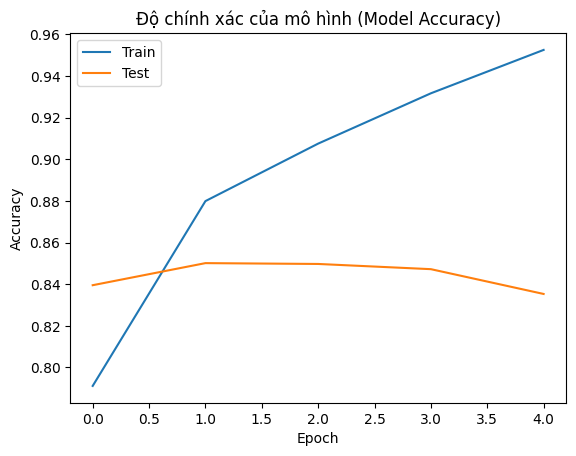

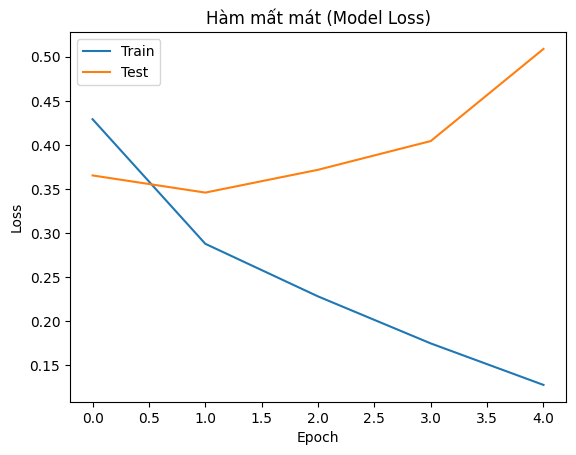

In [6]:
# ==========================================
# 5. ĐÁNH GIÁ KẾT QUẢ & VẼ BIỂU ĐỒ
# ==========================================

loss, accuracy = model.evaluate(testing_padded, testing_labels)
print(f'\nĐộ chính xác trên tập Test: {accuracy*100:.2f}%')

# Vẽ biểu đồ Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Độ chính xác của mô hình (Model Accuracy)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Vẽ biểu đồ Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Hàm mất mát (Model Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()